# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


ref: http://cs231n.github.io/linear-classify/  
ref: https://www.quora.com/What-is-the-intuition-behind-SoftMax-function  
ref: http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/  
ref: https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural_network_implementation_intermezzo02.ipynb

### Recap from lecture notes  
Unlike the SVM which treats the outputs $f(x_i,W)$ as (uncalibrated and possibly difficult to interpret) scores for each class, the Softmax classifier gives a slightly more intuitive output (normalized class probabilities) and also has a probabilistic interpretation that we will describe shortly. In the Softmax classifier, the function mapping $f(x_i,W)=Wx_i$ stays unchanged, but we now interpret these scores as the unnormalized log probabilities for each class and replace the hinge loss with a cross-entropy loss that has the form:  

$ L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j} $  
  
where we are using the notation $f_j$ to mean the j-th element of the vector of class scores f. As before, the __ full loss for the dataset __ is the mean of $L_i$ over all training examples together with a regularization term _R(W)_   
  

The function $ f_j(z) = \frac{e^{z_j}}{\sum_k e^{z_k}} $ is called the __ softmax function __  
> It takes a vector of arbitrary real-valued scores (in z) and squashes it to a vector of values between zero and one that sum to one.  

#### Information theory view
The __cross-entropy__ between a “true” distribution _p_ and an estimated distribution _q_ is defined as:
> $ H(p,q) = - \sum_x p(x) \log q(x) $

The __Softmax classifier__ is hence minimizing the cross-entropy between the estimated class probabilities (q) and the “true” distribution, which in this interpretation is the distribution where all probability mass is on the correct class (i.e. p=[0,…1,…,0]contains a single 1 at the $y_i$ -th 
position.). 

#### Probabilistic Interpretation  

$ P(y_i \mid x_i; W) = \frac{e^{f_{y_i}}}{\sum_j e^{f_j} } $

> interpreted as the (normalized) probability assigned to the correct label $y_i$ given the  
  image $x_i$ and parameterized by W  
  
#### Computing the Analytic Gradient with Backpropagation

Lets introduce the intermediate variable p, which is a vector of the (normalized) probabilities. The loss for one example is:  
> $ p_k = \frac{e^{f_k}}{ \sum_j e^{f_j} } \hspace{1in} L_i =-\log\left(p_{y_i}\right) $  

We now wish to understand how the computed scores inside f should change to decrease the loss Li that this example contributes to the full objective. In other words, we want to derive the gradient $ \partial L_i / \partial f_k $.  The loss $L_i$ is computed from p, which in turn depends on f.  

It turns out to be extremely simple and interpretible in the end, after a lot of things cancel out  
> $ \frac{\partial L_i }{ \partial f_k } = p_k - \mathbb{1}(y_i = k) $


Suppose the probabilities we computed were p = [0.2, 0.3, 0.5], and that the correct class was the middle one (with probability 0.3). According to this derivation the gradient on the scores would be df = [0.2, -0.7, 0.5].  Recalling what the interpretation of the gradient, we see that this result is highly intuitive: increasing the first or last element of the score vector f (the scores of the incorrect classes) leads to an increased loss (due to the positive signs +0.2 and +0.5) - and increasing the loss is bad, as expected. However, increasing the score of the correct class has negative influence on the loss. The gradient of -0.7 is telling us that increasing the correct class score would lead to a decrease of the loss $L_i$ , which makes sense.



In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)

  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))


loss: 2.345802
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** We have 10 classes and the total probabilities add up to 1. So each class will have a softmax probability of ~0.1. Our loss function with cross-entropy gives us -log(0.1).

We are just calculating the loss here with softmax; haven't yet done any update or gradient descent.


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.119174 analytic: -1.119174, relative error: 2.221960e-08
numerical: -1.679484 analytic: -1.679484, relative error: 2.576622e-08
numerical: -0.840921 analytic: -0.840921, relative error: 3.502196e-08
numerical: -0.235676 analytic: -0.235676, relative error: 2.266495e-07
numerical: 1.239482 analytic: 1.239482, relative error: 8.845553e-09
numerical: -4.031610 analytic: -4.031610, relative error: 2.625255e-08
numerical: 3.181765 analytic: 3.181765, relative error: 3.219812e-09
numerical: 1.028569 analytic: 1.028569, relative error: 2.830451e-08
numerical: 0.902671 analytic: 0.902670, relative error: 5.377363e-08
numerical: 1.319218 analytic: 1.319217, relative error: 3.814943e-08
numerical: -2.608444 analytic: -2.608444, relative error: 1.962640e-08
numerical: 0.130531 analytic: 0.130531, relative error: 2.370957e-07
numerical: -1.567271 analytic: -1.567271, relative error: 2.154221e-08
numerical: 0.506622 analytic: 0.506622, relative error: 2.203010e-08
numerical: -0.721004

In [9]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
t1 = toc - tic
print 'naive loss: %e computed in %fs' % (loss_naive, t1)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
t2 = toc - tic
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, t2)

print 'Speedup: {}'.format(t1/t2)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.345802e+00 computed in 0.088615s
vectorized loss: 2.345802e+00 computed in 0.008154s
Speedup: 10.8674600158
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
iters = 100
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)
        
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

cs231n/classifiers/softmax.py:106: RuntimeWarning: divide by zero encountered in log
  all_loss = -np.log(softmax_probabilities_for_all_y) # vector of size (N,) of Li computations for all N images
cs231n/classifiers/softmax.py:116: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)


lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.153633 val accuracy: 0.144000
lr 1.000000e-07 reg 1.000000e+08 train accuracy: 0.102571 val accuracy: 0.091000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.307735 val accuracy: 0.311000
lr 5.000000e-07 reg 1.000000e+08 train accuracy: 0.087510 val accuracy: 0.084000
best validation accuracy achieved during cross-validation: 0.311000


cs231n/classifiers/softmax.py:116: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.311000


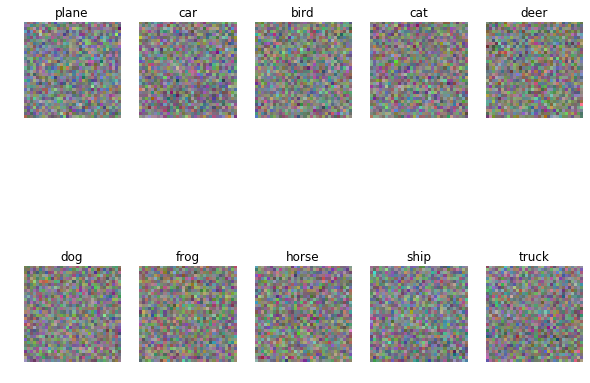

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])